In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import tensorflow as tf #machine learning
import numpy as np #matrix math
import datetime #logging the time for model checkpoints and training
import matplotlib.pyplot as plt #visualize results
%matplotlib inline

#Step 1 - Collect dataset
#MNIST - handwritten character digits ~50K training and validation images + labels, 10K testing
from tensorflow.examples.tutorials.mnist import input_data
#will ensure that the correct data has been downloaded to your 
#local training folder and then unpack that data to return a dictionary of DataSet instances.
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
def discriminator(x_image):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        # First convolutional and pool layers
        # These search for 32 different 5 x 5 pixel features
        #We’ll start off by passing the image through a convolutional layer. 
        #First, we create our weight and bias variables through tf.get_variable. 
        #Our first weight matrix (or filter) will be of size 5x5 and will have a output depth of 32. 
        #It will be randomly initialized from a normal distribution.
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        #tf.constant_init generates tensors with constant values.
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        #tf.nn.conv2d() is the Tensorflow’s function for a common convolution.
        #It takes in 4 arguments. The first is the input volume (our 28 x 28 x 1 image in this case). 
        #The next argument is the filter/weight matrix. Finally, you can also change the stride and 
        #padding of the convolution. Those two values affect the dimensions of the output volume.
        #"SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, 
        #it will add the extra column to the right,
        #strides = [batch, height, width, channels]
        d1 = tf.nn.conv2d(input=x_image, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        #add the bias
        d1 = d1 + d_b1
        #squash with nonlinearity (ReLU)
        d1 = tf.nn.relu(d1)
        ##An average pooling layer performs down-sampling by dividing the input into 
        #rectangular pooling regions and computing the average of each region. 
        #It returns the averages for the pooling regions.
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        #As with any convolutional neural network, this module is repeated, 
        # Second convolutional and pool layers
        # These search for 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

     #and then followed by a series of fully connected layers. 
    # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

    #The last fully-connected layer holds the output, such as the class scores.
    # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))

    #At the end of the network, we do a final matrix multiply and 
    #return the activation value. 
    #For those of you comfortable with CNNs, this is just a simple binary classifier. Nothing fancy.
    # Final layer
        d4 = tf.matmul(d3, d_w4) + d_b4
    # d4 dimensions: batch_size x 1

    return d4

In [0]:
#You can think of the generator as being a kind of reverse ConvNet. With CNNs, the goal is to 
#transform a 2 or 3 dimensional matrix of pixel values into a single probability. 
#A generator, however, seeks to take a d-dimensional noise vector and upsample it to become a 28 x 28 image. 
#ReLUs are then used to stabilize the outputs of each layer.
#example of CNN blocks http://cs231n.github.io/convolutional-networks/#fc

#it takes random inputs, and eventually mapping them down to a [1,28,28] pixel to match the MNIST data shape.  
#Be begin by generating a dense 14×14 set of values, and then run through a handful of filters of
#varying sizes and numbers of channels
#weight matrices get progressively smaller

def generator(batch_size, z_dim):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        z = tf.truncated_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
    #first deconv block
        g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g1 = tf.matmul(z, g_w1) + g_b1
        g1 = tf.reshape(g1, [-1, 56, 56, 1])
        g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
        g1 = tf.nn.relu(g1)

    # Generate 50 features
        g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
        g2 = g2 + g_b2
        g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
        g2 = tf.nn.relu(g2)
        g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
        g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
        g3 = g3 + g_b3
        g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
        g3 = tf.nn.relu(g3)
        g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
        g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
        g4 = g4 + g_b4
        g4 = tf.sigmoid(g4)

    # No batch normalization at the final layer, but we do add
    # a sigmoid activator to make the generated images crisper.
    # Dimensions of g4: batch_size x 28 x 28 x 1

    return g4

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
batch_size = 50
z_dimensions = 100

# x_placeholder is for feeding input images to the discriminator
x_placeholder = tf.placeholder("float", shape = [None,28,28,1], name='x_placeholder')

#One of the trickiest parts about understanding GANs is that the loss function is a little bit more complex than that
#of a traditional CNN classifiers (For those, a simple MSE or Hinge Loss would do the trick). 
#If you think back to the introduction, a GAN can be thought of as a zero sum minimax game. 
#The generator is constantly improving to produce more and more realistic images, while the discriminator is 
#trying to get better and better at distinguishing between real and generated images.
#This means that we need to formulate loss functions that affect both networks. 
#Let’s take a look at the inputs and outputs of our networks.

# Gz holds the generated images
#g(z)
Gz = generator(batch_size, z_dimensions)

# Dx hold the discriminator's prediction probabilities
# for real MNIST images
#d(x)
Dx = discriminator(x_placeholder)

# Dg holds discriminator prediction probabilities for generated images
#d(g(z))
Dg = discriminator(Gz)

#So, let’s first think about what we want out of our networks. We want the generator network to create 
#images that will fool the discriminator. The generator wants the discriminator to output a 1 (positive example).
#Therefore, we want to compute the loss between the Dg and label of 1. This can be done through 
#the tf.nn.sigmoid_cross_entropy_with_logits function. This means that the cross entropy loss will 
#be taken between the two arguments. The "with_logits" component means that the function will operate 
#on unscaled values. Basically, this means that instead of using a softmax function to squish the output
#activations to probability values from 0 to 1, we simply return the unscaled value of the matrix multiplication.
#Take a look at the last line of our discriminator. There's no softmax or sigmoid layer at the end.
#The reduce mean function just takes the mean value of all of the components in the matrixx returned 
#by the cross entropy function. This is just a way of reducing the loss to a single scalar value, 
#instead of a vector or matrix.
#https://datascience.stackexchange.com/questions/9302/the-cross-entropy-error-function-in-neural-networks

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))


#Now, let’s think about the discriminator’s point of view. Its goal is to just get the correct labels 
#(output 1 for each MNIST digit and 0 for the generated ones). We’d like to compute the loss between Dx 
#and the correct label of 1 as well as the loss between Dg and the correct label of 0.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.fill([batch_size, 1], 0.9)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Train the discriminator
# Increasing from 0.001 in GitHub version
with tf.variable_scope(tf.get_variable_scope(), reuse=False) as scope:
    #Next, we specify our two optimizers. In today’s era of deep learning, Adam seems to be the
    #best SGD optimizer as it utilizes adaptive learning rates and momentum. 
    #We call Adam's minimize function and also specify the variables that we want it to update.
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars)
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars)

    # Train the generator
    # Decreasing from 0.004 in GitHub version
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)


In [8]:
#Outputs a Summary protocol buffer containing a single scalar value.
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

d_real_count_ph = tf.placeholder(tf.float32)
d_fake_count_ph = tf.placeholder(tf.float32)
g_count_ph = tf.placeholder(tf.float32)

tf.summary.scalar('d_real_count', d_real_count_ph)
tf.summary.scalar('d_fake_count', d_fake_count_ph)
tf.summary.scalar('g_count', g_count_ph)

# Sanity check to see how the discriminator evaluates
# generated and real MNIST images
d_on_generated = tf.reduce_mean(discriminator(generator(batch_size, z_dimensions)))
d_on_real = tf.reduce_mean(discriminator(x_placeholder))

tf.summary.scalar('d_on_generated_eval', d_on_generated)
tf.summary.scalar('d_on_real_eval', d_on_real)

images_for_tensorboard = generator(batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 10)
merged = tf.summary.merge_all()
logdir = "tensorboard/gan/"
writer = tf.summary.FileWriter(logdir, sess.graph)
print(logdir)

tensorboard/gan/


TRAINING STEP 0 AT 2018-08-23 03:33:34.698759
Discriminator classification [0.00216767]


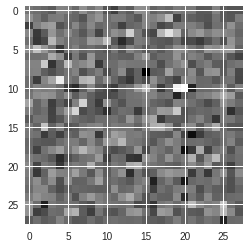

Discriminator classification [0.00216744]


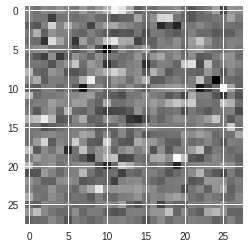

Discriminator classification [0.00213455]


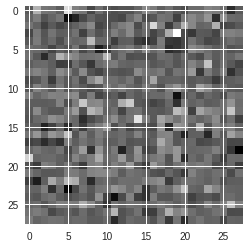

saved to models/pretrained_gan.ckpt-0
TRAINING STEP 1000 AT 2018-08-23 03:34:16.357227
Discriminator classification [-0.28475186]


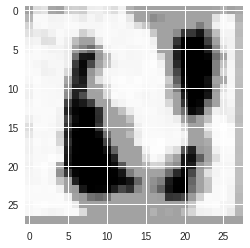

Discriminator classification [-0.3009611]


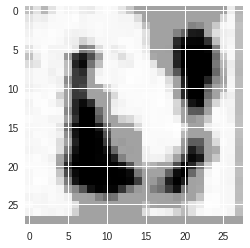

Discriminator classification [-0.16252913]


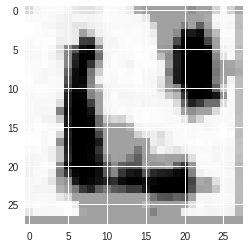

TRAINING STEP 2000 AT 2018-08-23 03:34:54.765600
Discriminator classification [-0.46743035]


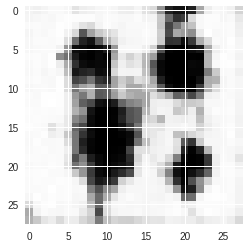

Discriminator classification [-0.40639824]


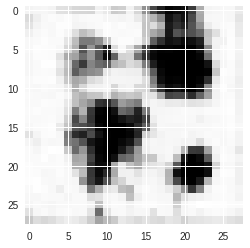

Discriminator classification [-0.3797829]


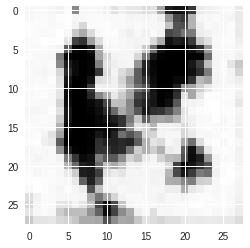

TRAINING STEP 3000 AT 2018-08-23 03:35:34.711897
Discriminator classification [-0.27719304]


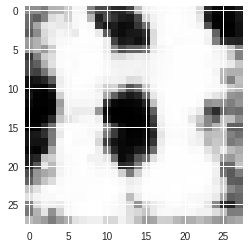

Discriminator classification [-0.24844123]


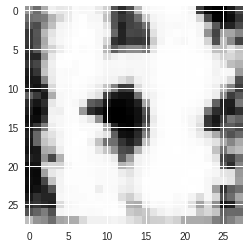

Discriminator classification [-0.3041416]


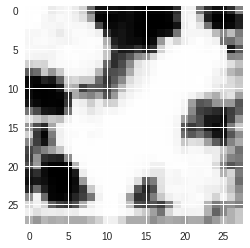

TRAINING STEP 4000 AT 2018-08-23 03:36:16.233019
Discriminator classification [-0.26450685]


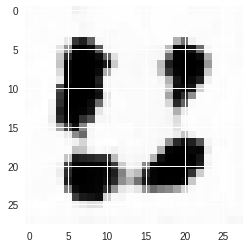

Discriminator classification [-0.27593407]


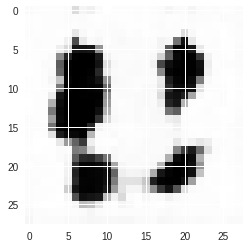

Discriminator classification [-0.14089847]


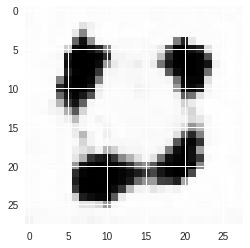

TRAINING STEP 5000 AT 2018-08-23 03:37:00.207227
Discriminator classification [0.2665397]


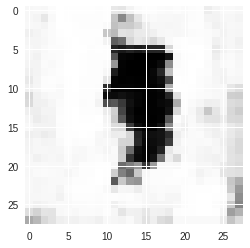

Discriminator classification [0.23160744]


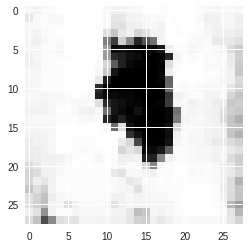

Discriminator classification [0.29974055]


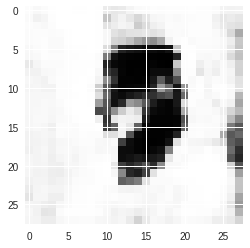

saved to models/pretrained_gan.ckpt-5000
TRAINING STEP 6000 AT 2018-08-23 03:37:48.501450
Discriminator classification [-0.3645967]


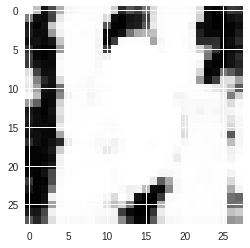

Discriminator classification [-1.1315118]


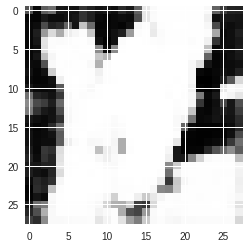

Discriminator classification [-1.0751125]


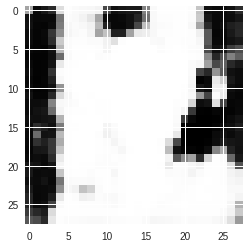

TRAINING STEP 7000 AT 2018-08-23 03:38:30.754608
Discriminator classification [0.13331932]


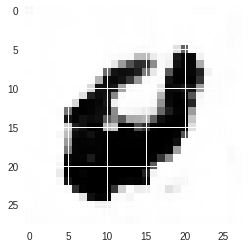

Discriminator classification [0.22120419]


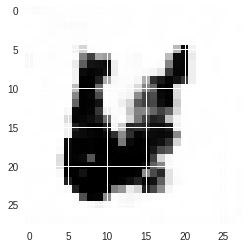

Discriminator classification [0.44382]


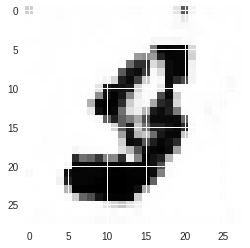

TRAINING STEP 8000 AT 2018-08-23 03:39:19.850303
Discriminator classification [-0.41022986]


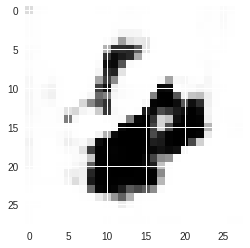

Discriminator classification [0.06763681]


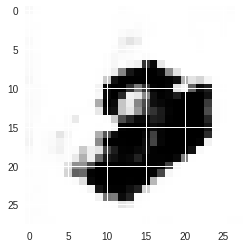

Discriminator classification [-0.0620252]


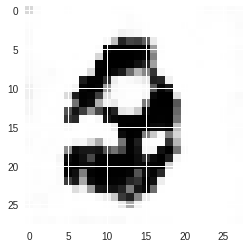

TRAINING STEP 9000 AT 2018-08-23 03:39:58.947635
Discriminator classification [-0.65167135]


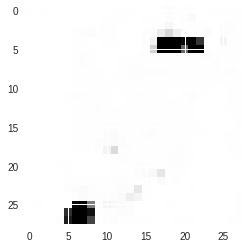

Discriminator classification [-0.2061161]


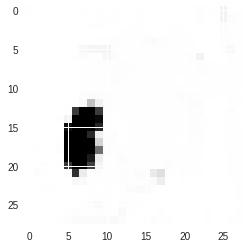

Discriminator classification [-0.13441274]


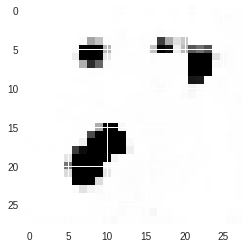

TRAINING STEP 10000 AT 2018-08-23 03:40:45.826422
Discriminator classification [0.30923927]


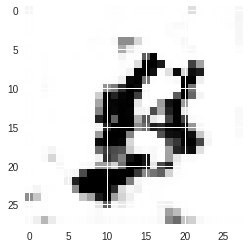

Discriminator classification [1.5805652]


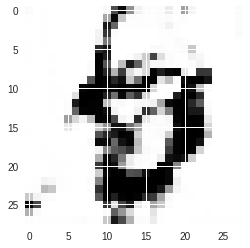

Discriminator classification [0.17803024]


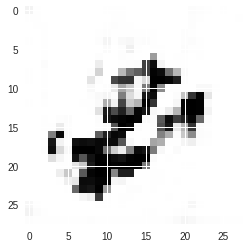

saved to models/pretrained_gan.ckpt-10000
TRAINING STEP 11000 AT 2018-08-23 03:41:39.867431
Discriminator classification [0.27279282]


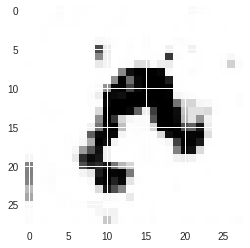

Discriminator classification [-0.30255255]


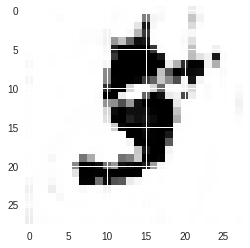

Discriminator classification [-0.08464076]


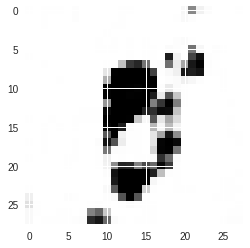

TRAINING STEP 12000 AT 2018-08-23 03:42:33.427242
Discriminator classification [0.47903958]


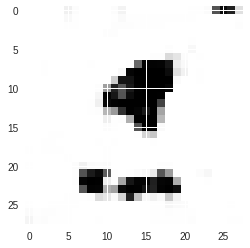

Discriminator classification [0.6266311]


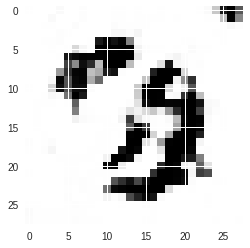

Discriminator classification [0.2167241]


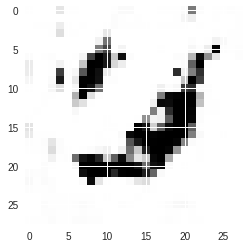

TRAINING STEP 13000 AT 2018-08-23 03:43:34.360352
Discriminator classification [0.30630332]


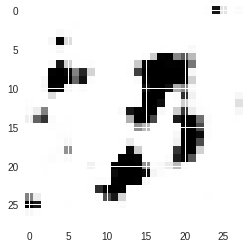

Discriminator classification [0.28512356]


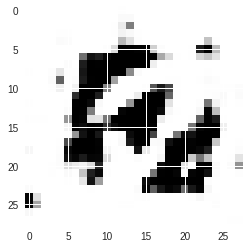

Discriminator classification [0.5835952]


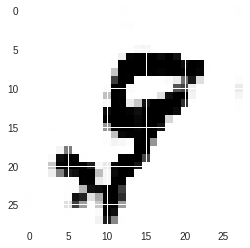

TRAINING STEP 14000 AT 2018-08-23 03:44:26.924318
Discriminator classification [0.34293762]


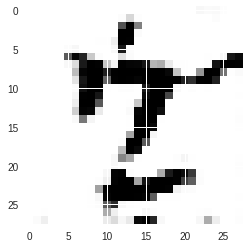

Discriminator classification [0.35348964]


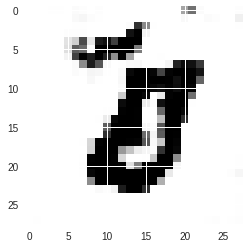

Discriminator classification [0.43034336]


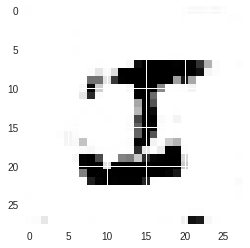

TRAINING STEP 15000 AT 2018-08-23 03:45:13.203042
Discriminator classification [0.50591403]


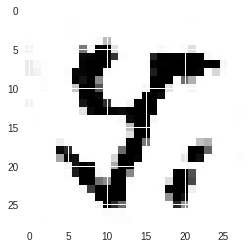

Discriminator classification [0.27111056]


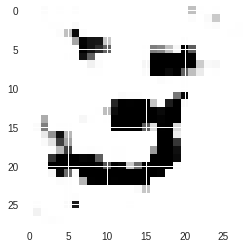

Discriminator classification [0.4628738]


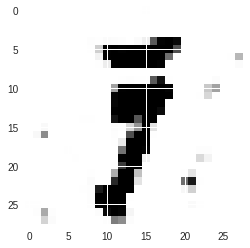

saved to models/pretrained_gan.ckpt-15000
TRAINING STEP 16000 AT 2018-08-23 03:46:01.030457
Discriminator classification [0.08958974]


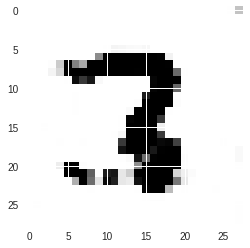

Discriminator classification [0.4403827]


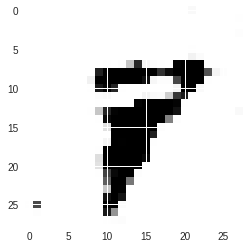

Discriminator classification [-0.10394859]


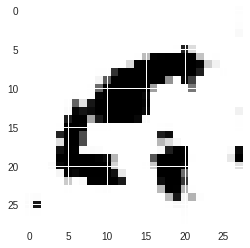

TRAINING STEP 17000 AT 2018-08-23 03:46:45.348116
Discriminator classification [0.5037191]


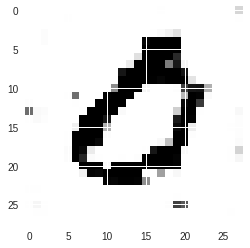

Discriminator classification [0.6695679]


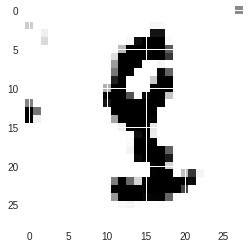

Discriminator classification [1.0365146]


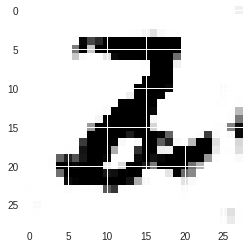

TRAINING STEP 18000 AT 2018-08-23 03:47:31.893064
Discriminator classification [1.0533836]


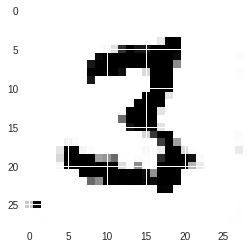

Discriminator classification [0.94013524]


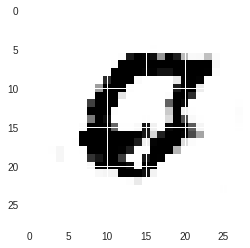

Discriminator classification [1.523212]


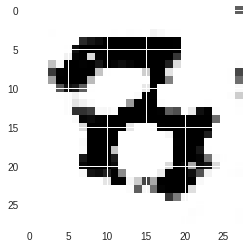

TRAINING STEP 19000 AT 2018-08-23 03:48:18.138717
Discriminator classification [0.01087164]


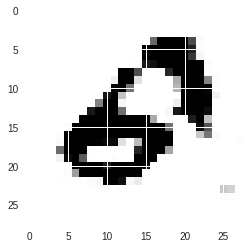

Discriminator classification [0.24037778]


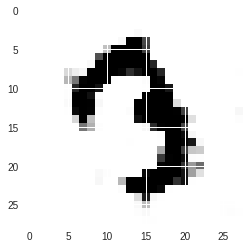

Discriminator classification [0.4633785]


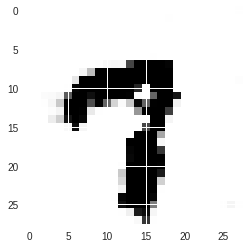

TRAINING STEP 20000 AT 2018-08-23 03:49:05.353820
Discriminator classification [0.13131279]


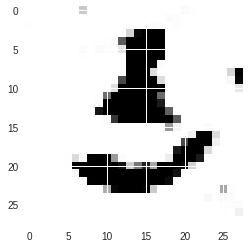

Discriminator classification [0.10479519]


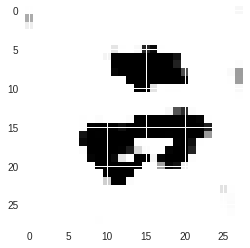

Discriminator classification [0.18719417]


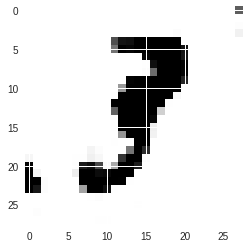

saved to models/pretrained_gan.ckpt-20000
TRAINING STEP 21000 AT 2018-08-23 03:49:52.339877
Discriminator classification [0.8360334]


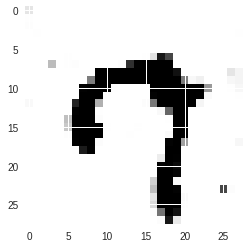

Discriminator classification [0.31537327]


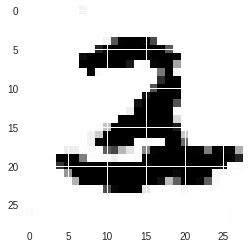

Discriminator classification [0.01508281]


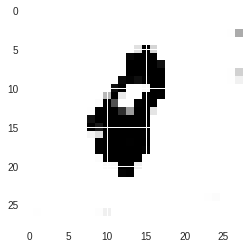

TRAINING STEP 22000 AT 2018-08-23 03:50:38.667025
Discriminator classification [0.4762925]


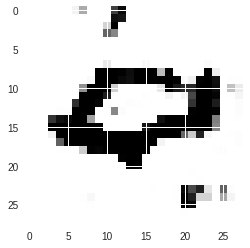

Discriminator classification [-0.1514299]


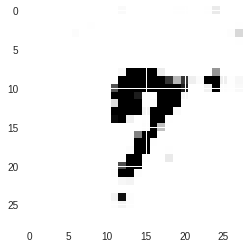

Discriminator classification [-0.12028718]


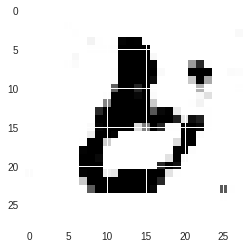

TRAINING STEP 23000 AT 2018-08-23 03:51:24.562143
Discriminator classification [0.01738429]


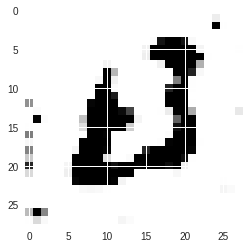

Discriminator classification [0.35045558]


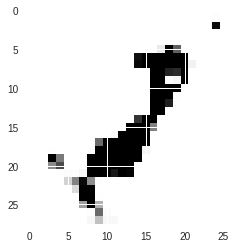

Discriminator classification [0.21717146]


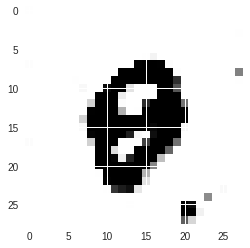

TRAINING STEP 24000 AT 2018-08-23 03:52:09.705426
Discriminator classification [0.95912606]


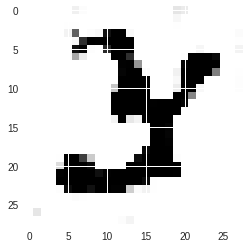

Discriminator classification [0.63846433]


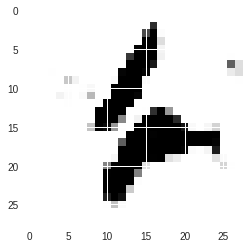

Discriminator classification [0.31783482]


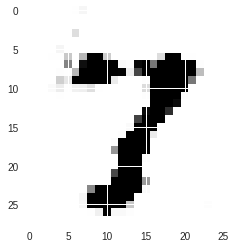

TRAINING STEP 25000 AT 2018-08-23 03:52:53.809029
Discriminator classification [0.07144596]


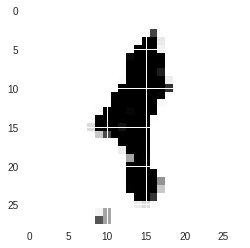

Discriminator classification [0.32433012]


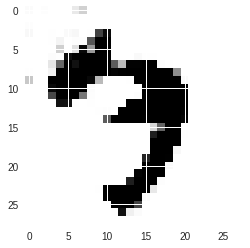

Discriminator classification [0.24399343]


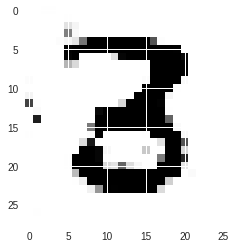

saved to models/pretrained_gan.ckpt-25000
TRAINING STEP 26000 AT 2018-08-23 03:53:36.788465
Discriminator classification [2.6862757]


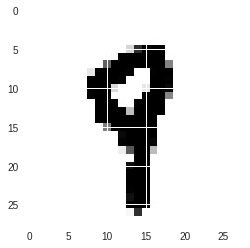

Discriminator classification [3.4094718]


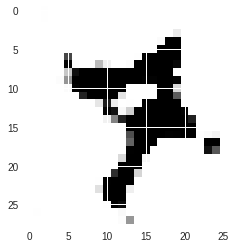

Discriminator classification [2.7409053]


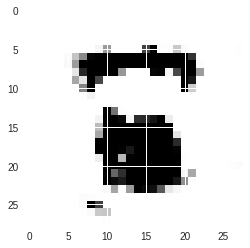

TRAINING STEP 27000 AT 2018-08-23 03:54:20.029813
Discriminator classification [4.9521084]


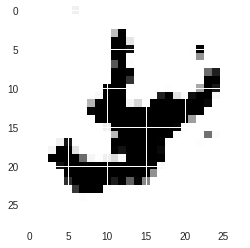

Discriminator classification [3.4173212]


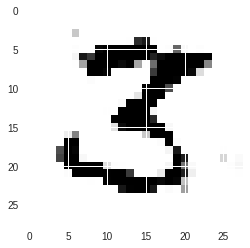

Discriminator classification [2.3411005]


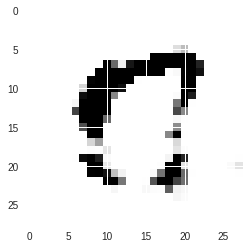

TRAINING STEP 28000 AT 2018-08-23 03:55:04.409916
Discriminator classification [-0.23345579]


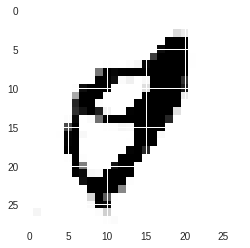

Discriminator classification [0.49748743]


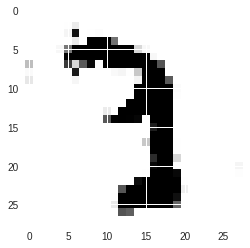

Discriminator classification [0.24537502]


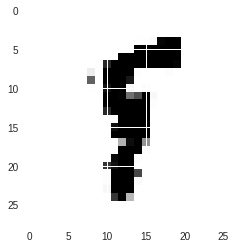

TRAINING STEP 29000 AT 2018-08-23 03:55:48.914072
Discriminator classification [-0.9858867]


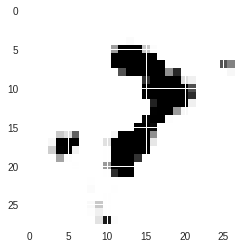

Discriminator classification [-0.5381905]


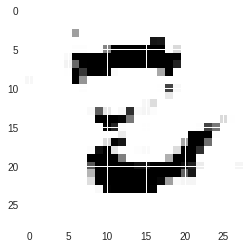

Discriminator classification [-0.5650741]


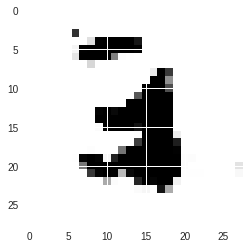

TRAINING STEP 30000 AT 2018-08-23 03:56:33.395998
Discriminator classification [1.5170032]


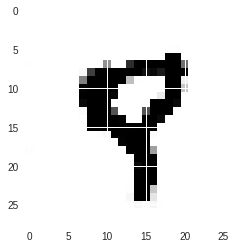

Discriminator classification [-0.70568883]


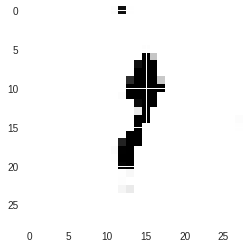

Discriminator classification [1.1635629]


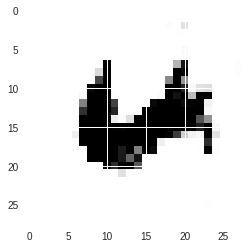

saved to models/pretrained_gan.ckpt-30000
TRAINING STEP 31000 AT 2018-08-23 03:57:17.937232
Discriminator classification [7.345415]


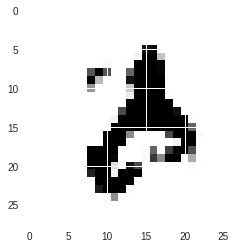

Discriminator classification [9.244805]


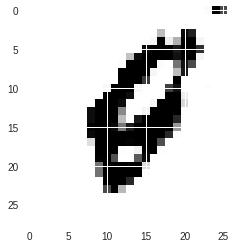

Discriminator classification [7.6007037]


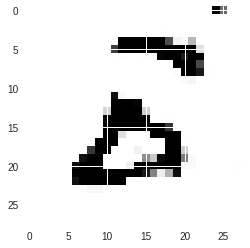

TRAINING STEP 32000 AT 2018-08-23 03:58:02.122906
Discriminator classification [9.12143]


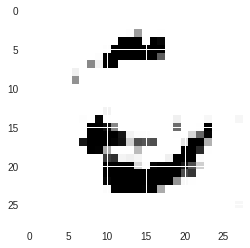

Discriminator classification [10.365732]


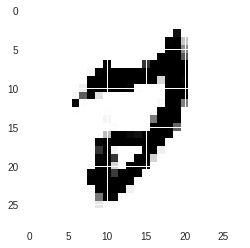

Discriminator classification [7.3215175]


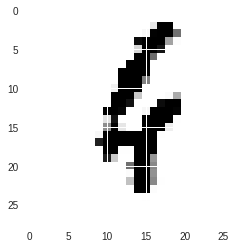

TRAINING STEP 33000 AT 2018-08-23 03:58:45.702853
Discriminator classification [9.029684]


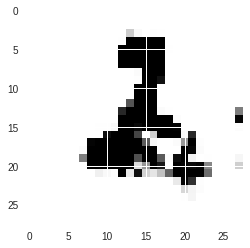

Discriminator classification [5.79465]


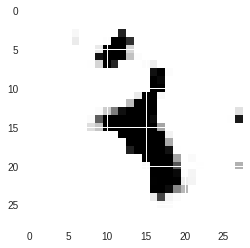

Discriminator classification [8.466459]


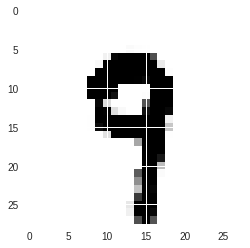

TRAINING STEP 34000 AT 2018-08-23 03:59:28.390254
Discriminator classification [3.9133477]


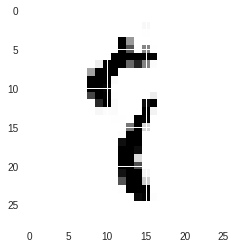

Discriminator classification [7.1210546]


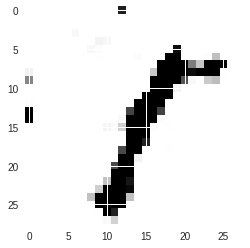

Discriminator classification [4.814936]


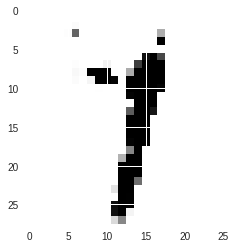

TRAINING STEP 35000 AT 2018-08-23 04:00:11.286940
Discriminator classification [6.3343377]


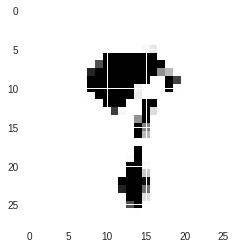

Discriminator classification [7.129822]


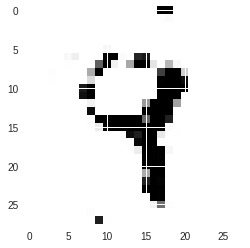

Discriminator classification [6.81164]


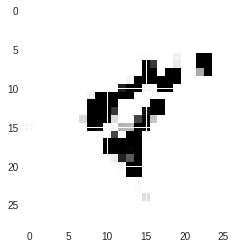

saved to models/pretrained_gan.ckpt-35000
TRAINING STEP 36000 AT 2018-08-23 04:00:54.597256
Discriminator classification [2.4246795]


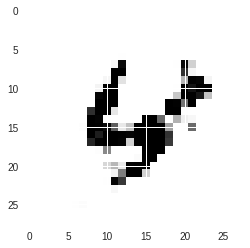

Discriminator classification [-0.01957234]


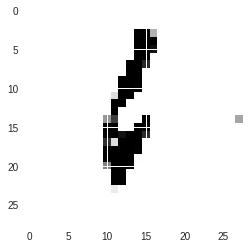

Discriminator classification [0.7467045]


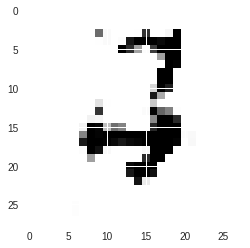

TRAINING STEP 37000 AT 2018-08-23 04:01:37.273182
Discriminator classification [-3.8295891]


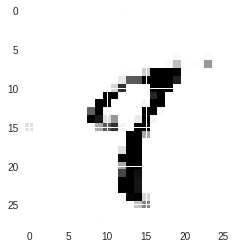

Discriminator classification [-4.5839343]


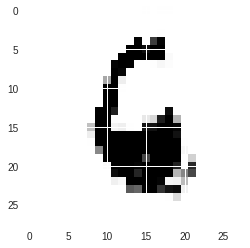

Discriminator classification [-3.2072442]


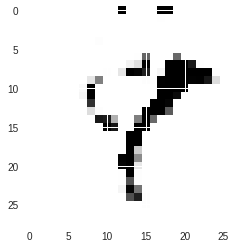

TRAINING STEP 38000 AT 2018-08-23 04:02:19.924790
Discriminator classification [0.768127]


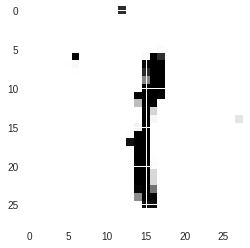

Discriminator classification [5.7381306]


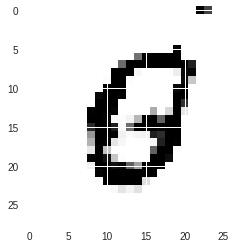

Discriminator classification [3.410914]


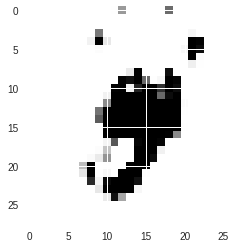

TRAINING STEP 39000 AT 2018-08-23 04:03:02.995604
Discriminator classification [-0.8829342]


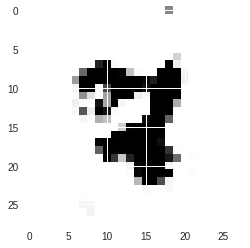

Discriminator classification [-1.6110579]


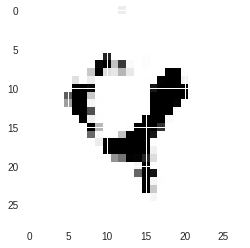

Discriminator classification [1.2211984]


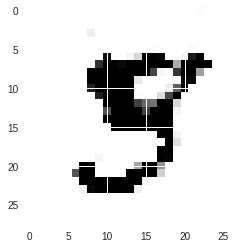

TRAINING STEP 40000 AT 2018-08-23 04:03:46.132136
Discriminator classification [-7.3502293]


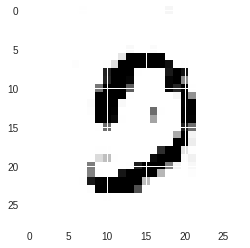

Discriminator classification [-6.4864745]


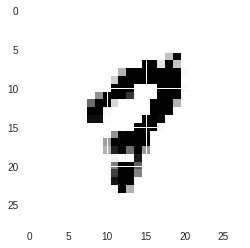

Discriminator classification [-5.3767653]


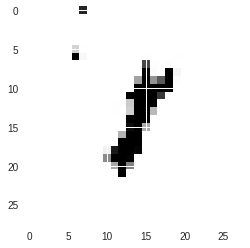

saved to models/pretrained_gan.ckpt-40000
TRAINING STEP 41000 AT 2018-08-23 04:04:30.564724
Discriminator classification [4.189906]


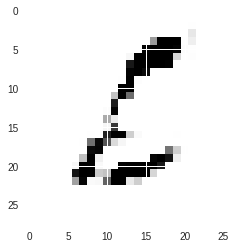

Discriminator classification [3.0930145]


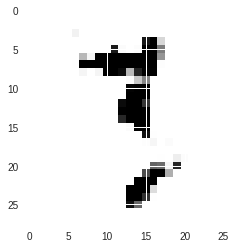

Discriminator classification [2.5951588]


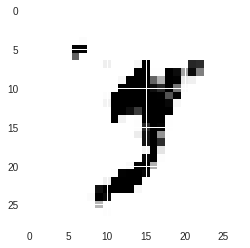

TRAINING STEP 42000 AT 2018-08-23 04:05:14.447287
Discriminator classification [6.3119106]


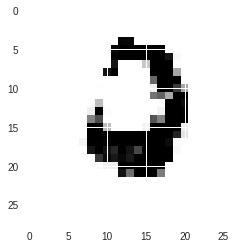

Discriminator classification [4.2713685]


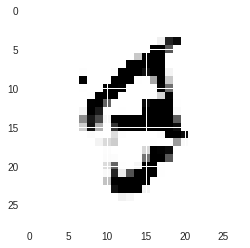

Discriminator classification [4.8472695]


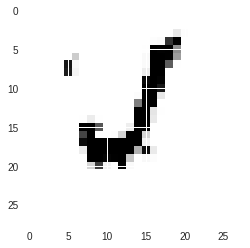

TRAINING STEP 43000 AT 2018-08-23 04:05:57.581708
Discriminator classification [9.076982]


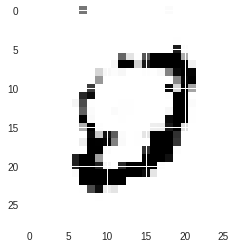

Discriminator classification [8.614556]


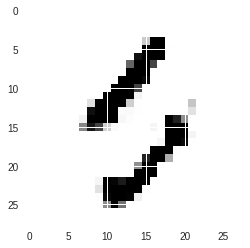

Discriminator classification [5.55797]


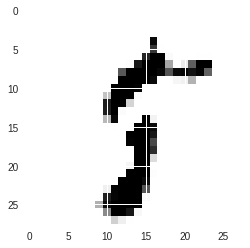

TRAINING STEP 44000 AT 2018-08-23 04:06:40.779155
Discriminator classification [4.5431423]


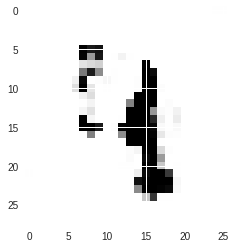

Discriminator classification [6.973013]


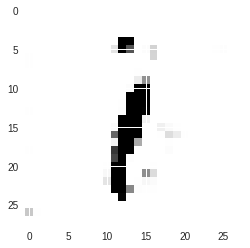

Discriminator classification [11.88385]


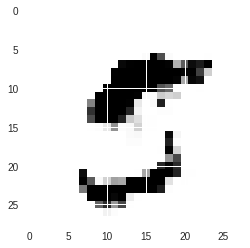

TRAINING STEP 45000 AT 2018-08-23 04:07:23.703676
Discriminator classification [6.7413445]


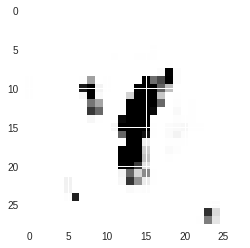

Discriminator classification [15.607143]


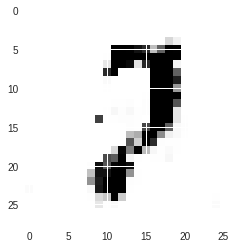

Discriminator classification [13.123375]


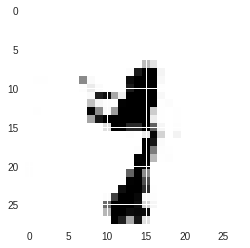

saved to models/pretrained_gan.ckpt-45000
TRAINING STEP 46000 AT 2018-08-23 04:08:07.274095
Discriminator classification [12.229091]


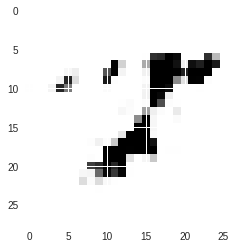

Discriminator classification [15.123004]


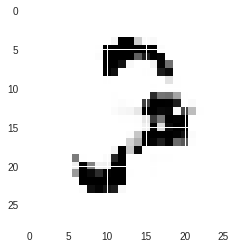

Discriminator classification [13.433373]


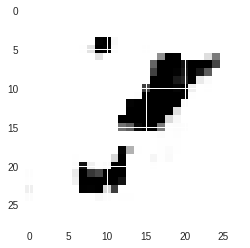

TRAINING STEP 47000 AT 2018-08-23 04:08:50.249465
Discriminator classification [5.889711]


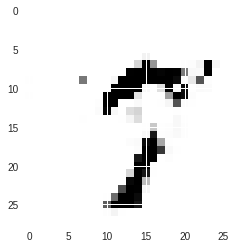

Discriminator classification [7.3656]


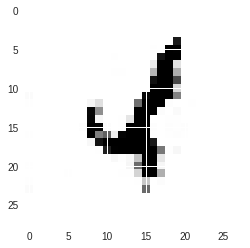

Discriminator classification [8.136096]


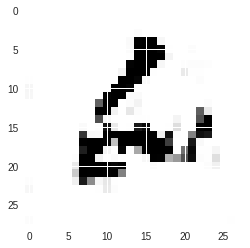

TRAINING STEP 48000 AT 2018-08-23 04:09:33.119638
Discriminator classification [6.931032]


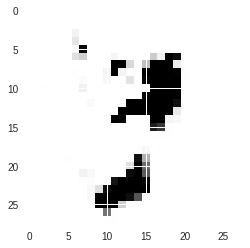

Discriminator classification [6.5200787]


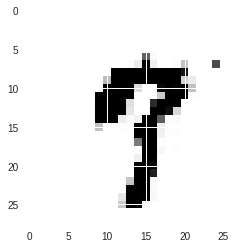

Discriminator classification [7.7594624]


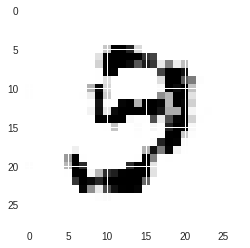

TRAINING STEP 49000 AT 2018-08-23 04:10:16.694897
Discriminator classification [6.443868]


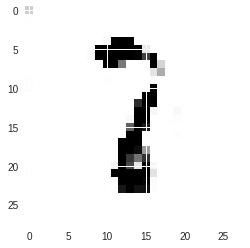

Discriminator classification [11.777175]


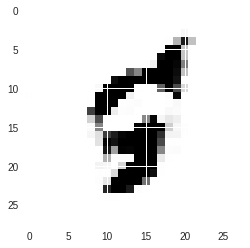

Discriminator classification [9.35357]


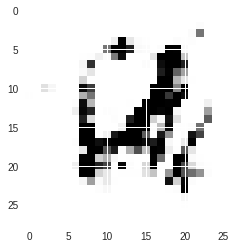

In [9]:
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

#During every iteration, there will be two updates being made, one to the discriminator and one to the generator. 
#For the generator update, we’ll feed in a random z vector to the generator and pass that output to the discriminator
#to obtain a probability score (this is the Dg variable we specified earlier).
#As we remember from our loss function, the cross entropy loss gets minimized, 
#and only the generator’s weights and biases get updated.
#We'll do the same for the discriminator update. We’ll be taking a batch of images 
#from the mnist variable we created way at the beginning of our program.
#These will serve as the positive examples, while the images in the previous section are the negative ones.

gLoss = 0
dLossFake, dLossReal = 1, 1
d_real_count, d_fake_count, g_count = 0, 0, 0
for i in range(50000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    if dLossFake > 0.6:
        # Train discriminator on generated images
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_fake, d_loss_real, d_loss_fake, g_loss], {x_placeholder: real_image_batch})
        d_fake_count += 1

    if gLoss > 0.5:
        # Train the generator
        _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, d_loss_real, d_loss_fake, g_loss], {x_placeholder: real_image_batch})
        g_count += 1

    if dLossReal > 0.45:
        # If the discriminator classifies real images as fake,
        # train discriminator on real values
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_real, d_loss_real, d_loss_fake, g_loss], {x_placeholder: real_image_batch})
        d_real_count += 1

    if i % 10 == 0:
        real_image_batch = mnist.validation.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        summary = sess.run(merged, {x_placeholder: real_image_batch, d_real_count_ph: d_real_count, d_fake_count_ph: d_fake_count, g_count_ph: g_count})
        writer.add_summary(summary, i)
        d_real_count, d_fake_count, g_count = 0, 0, 0

    if i % 1000 == 0:
        # Periodically display a sample image in the notebook
        # (These are also being sent to TensorBoard every 10 iterations)
        images = sess.run(generator(3, z_dimensions))
        d_result = sess.run(discriminator(x_placeholder), {x_placeholder: images})
        print("TRAINING STEP", i, "AT", datetime.datetime.now())
        for j in range(3):
            print("Discriminator classification", d_result[j])
            im = images[j, :, :, 0]
            plt.imshow(im.reshape([28, 28]), cmap='Greys')
            plt.show()

    if i % 5000 == 0:
        save_path = saver.save(sess, "models/pretrained_gan.ckpt", global_step=i)
        print("saved to %s" % save_path)

[11.8019]


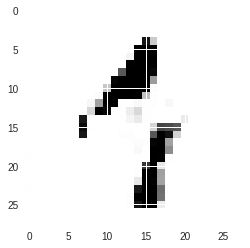

[17.675106]


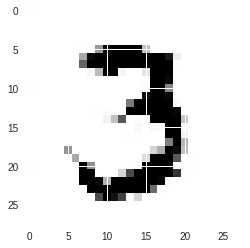

[20.116531]


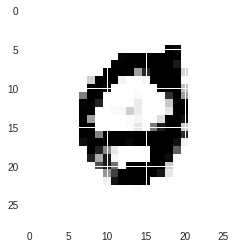

[13.558486]


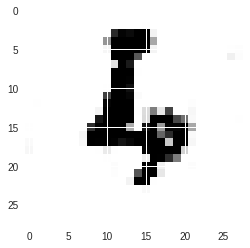

[13.3534]


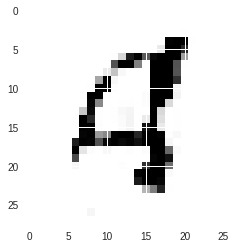

[9.865581]


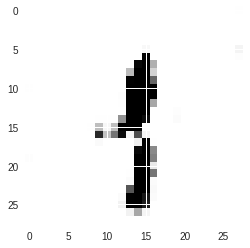

[12.891936]


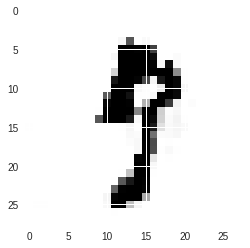

[13.435313]


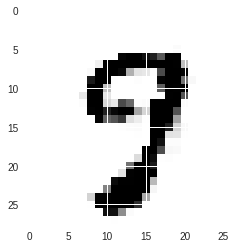

[11.53229]


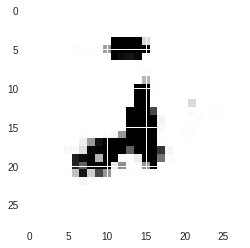

[14.548675]


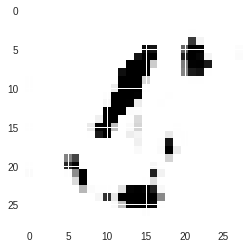

[14.924537]


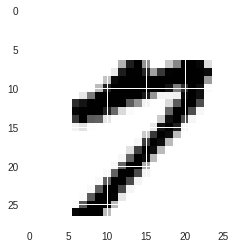

[9.363708]


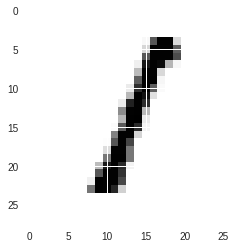

[11.553252]


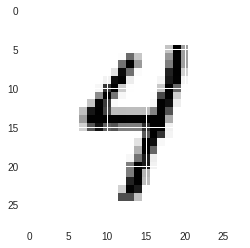

[13.287047]


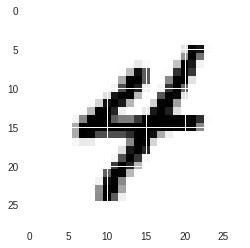

[18.402546]


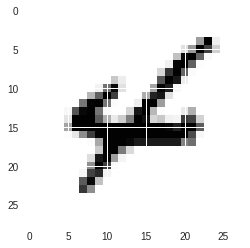

[15.959449]


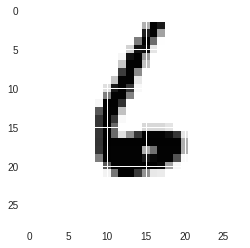

[10.94033]


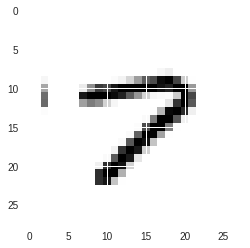

[14.09291]


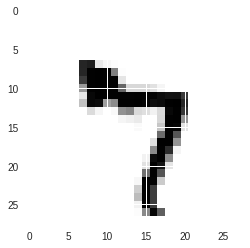

[15.137671]


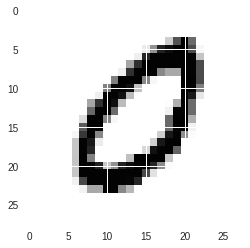

[19.195683]


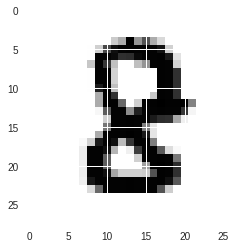

In [10]:
test_images = sess.run(generator(10, 100))
test_eval = sess.run(discriminator(x_placeholder), {x_placeholder: test_images})

real_images = mnist.validation.next_batch(10)[0].reshape([10, 28, 28, 1])
real_eval = sess.run(discriminator(x_placeholder), {x_placeholder: real_images})

# Show discriminator's probabilities for the generated images,
# and display the images
for i in range(10):
    print(test_eval[i])
    plt.imshow(test_images[i, :, :, 0], cmap='Greys')
    plt.show()

# Now do the same for real MNIST images
for i in range(10):
    print(real_eval[i])
    plt.imshow(real_images[i, :, :, 0], cmap='Greys')
    plt.show()
